# Walkthrough for HIPPS-DIMES

Pre-requisites:

* Basic Python knowledge
* Some experience with the Numpy and Scipy

To navigate this notebook:

* First install the python script/module by running `pip install --editable .` in the terminal
* Click on a code cell and execute its code by pressing `shift+enter` or clicking the `play` button on the toolbar
* During the execution of the code cell, the prompt on the left is displayed as `[*]:`. It will display the execution count when the execution is finished.
* The output of each code cell is displayed below each cell

---

**First, install the Dimes module by running the following code cell**

In [ ]:
%%bash

pip install --editable .

**Next, we can display the help information for available arguments and options the script accepts by using `--help` option**

In [ ]:
%%bash

python DIMES.py --help

---

## Overview

The program accept a input file, which can be either a mean spatial distance map or a Hi-C contact map, and then generate an ensemble of structures of x, y, z coordinates of genomic loci.

If the input file is a Hi-C contact map, then it can be either [`cooler`](https://open2c.github.io/cooler/) format or pure text format. 

If the input file is a mean spatial distance map, then it should be pure text format.

The program accepts a number of arguments and options. The full list of arguments and options and their descriptions can be found in the README file

---

## Example (Application on mean spatial distance map)

To run the examples below, first import packages which will be used later. If any of these packages are not installed, install them using either `pip` or `conda` in the terminal

In [25]:
import cooler
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy
import scipy.spatial

The Multiplexed FISH data used in this example can be obtained from the Github repository https://github.com/BogdanBintu/ChromatinImaging. First, define a function to streamline the converting experiment data to mean spatial distance which will be later fed into the program

In [14]:
# helper functions
def xyz2dmap(xyz, a):
    """
    Return distance map provided the xyz coordinates
    """
    return np.power(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(xyz)), a)

def df2xyz(df):
    xyz = df[['Z', 'X', 'Y']].values
    return xyz

def df2dmap(df):
    xyz = df2xyz(df)
    dmapsquare = xyz2dmap(xyz, 1.0)
    return dmapsquare

# define function to streamline the converting experiment data to mean spatial distance
def data2dmap(fin):
    df = pd.read_csv(fin, header=1)
    grouped = df.groupby('Chromosome index')
    xyz_exp_all = []
    dmap_exp_all = []
    for key in grouped.groups.keys():
        xyz_exp_all.append(df2xyz(grouped.get_group(key)))
        dmap_exp_all.append(df2dmap(grouped.get_group(key)))
    xyz_exp_all = np.array(xyz_exp_all)
    dmap_exp_all = np.array(dmap_exp_all)
    dmap_exp_mean = np.nanmean(dmap_exp_all, axis=0)
    return dmap_exp_mean

Then load and process the data

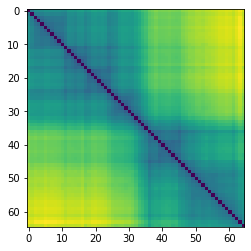

In [21]:
imr90_chr21_28_30_dmap_mean = data2dmap('data/IMR90_chr21-28-30Mb.csv')

# Plot the distance map
fig, ax = plt.subplots()
ax.imshow(imr90_chr21_28_30_dmap_mean)
plt.show()

# now save the result
np.savetxt('data/IMR90_chr21-28-30Mb.dmap', imr90_chr21_28_30_dmap_mean)

Now, open the terminal and then run the command below in this folder

```
python DIMES.py data/IMR90_chr21-28-30Mb.dmap imr90_chr21_28_30 --input-type dmap --input-format text
```
The command above dows the following,

* specify the path to the input file `data/IMR90_chr21-28-30Mp.dmap`. This argument is **required**
* specify the output prefix to be `imr90_chr21_28_30`. All the output files' name will start with `imr90_chr21_28_30_`. This argument is **required**
* specify that the type of the input file is `dmap` which indicates that it is a mean spatial distance map. This option is **required**
* specify that the format of the input contact map is `text`. This option is **required**
* specify the number of individual conformations to be 1000. This option is **optional**. If without specified, default value is 1000
* specify the number of iterations to be 10000. This option is **optional**. If without specified, default value is 10000
  

The program should finish within a few minutes. After completion, a few files are generated including `imr90_chr21_28_30_connectivity_matrix.txt`, `imr90_chr21_28_30_dmap_final.txt` and `imr90_chr21_28_30.xyz`. Now let's load the file `imr90_chr21_28_30_dmap_final.txt` which is the learnt mean distance map and compare it to the target.

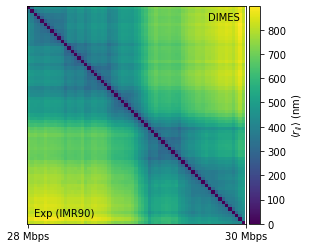

In [28]:
maxent_dmap = np.loadtxt('imr90_chr21_28_30_dmap_final.txt')

fig, ax = plt.subplots()
img = ax.imshow(np.tril(imr90_chr21_28_30_dmap_mean)+np.triu(maxent_dmap))
ax.text(0.9,0.95,'DIMES',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.text(0.17,0.05,'Exp (IMR90)',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.set_xticks([0,65])
ax.set_yticks([])
ax.set_xticklabels(['28 Mbps', '30 Mbps'])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(img, cax=cax)
cbar.set_label(r'$\langle r_{ij}\rangle\ (\mathrm{nm})$')
plt.show()

---

## Examples (Application on Hi-C contact map)

In this example, the input file is the Hi-C contact map instead of the distance map. The program convert the Hi-C contact map to a target distance map **internally** using a power law. This conversion is based on the polymer physics argument. It can be proved that in a typical polymer model, the relation between the mean distance and the contact probability is power law whose expoenent is system-dependent. By default, this exponent is 4.0 but can be manually set to be any positive number. 

First, let's import the exampled cooler file under the directory `data` and plot it

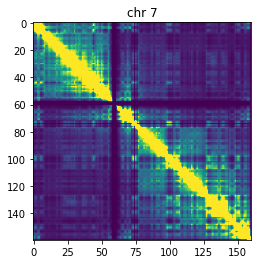

In [4]:
# import cooler file using Cooler package
cmap = cooler.Cooler('data/Rao2014-GM12878-MboI-allreps-filtered.1000kb.cool')
cmap_chr7 = cmap.matrix(balance=False).fetch('chr7')

# plot the Hi-C contact map for chromosome 7
fig, ax = plt.subplots()
ax.imshow(cmap_chr7, vmax=10000)
ax.set_title('chr 7')
plt.show()

Now, let's run the DIMES algorithm on this Hi-C contact map and generate an ensemble of structures.

Open the terminal and then run the command below in this folder.

```
python DIMES.py data/rao2014-gm12878-mboi-allreps-filtered.1000kb.cool rao2014 --input-type cmap --input-format cooler -s chr7 -e 1000 -i 1000 --log
```

The command above dows the following,

* specify that the type of the input file is `cmap` which indicates that it is a contact map. This option is **required**
* specify that the format of the input contact map is `cooler`. This option is **required**
* specify the genome region for the structures to be `chr7` which means Chromosome 7. This option is **required**
if the input file is in `cooler` format.
* turn on the log file. Once the program ran successfully, a log file named `cost_function_iteration.csv` will be generated. This option is **optional**

Let's have a look at the results generated. The output files are,

* `rao2014.xyz`: A `.xyz` formatted trajectory file containing 10 sets of x,y,z coordinates of genomic loci
* `rao2014_dmap_final.txt`: A text foramtted simulated mean distance matrix map.
* `rao2014_cmap_final.txt`: A text formatted simulated contact map.
* `rao2014_connectivity_matrix.txt`: A text formatted file containing the matrix of $k_{ij}$
* `cost_function_iteration.csv`: A CSV formatted file containing the cost value for each step of iterations.

First, we can plot the `cost_function_iteration.csv` to see the cost as a function of iteration steps,

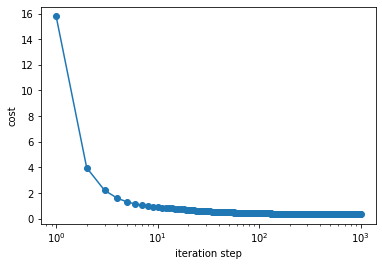

In [6]:
# read the file
cost_iteration = pd.read_csv('cost_function_iteration.csv')

# plot
fig, ax = plt.subplots()
ax.plot(cost_iteration['iteration'],\
       cost_iteration['cost'], marker='o')
ax.set_xscale('log')
ax.set_xlabel('iteration step')
ax.set_ylabel('cost')
plt.show()

As one can see, the cost goes down as the iteration step increases. Typically, for larger size of input contact map or distance map, the higher number of iteration steps for good convergence (low cost value) is needed. In this particular case, since our size of contact map is only 160x160, thus 1000 iteration steps are good enough.

Next, let's read the _simulated_ contact map and plot it side by side with the inputted Hi-C map,

In [ ]:
# load the contact map from the generated structures
cmap_model = np.loadtxt('rao2014_cmap_final.txt')

# plot the contact map from the model with the Hi-C contact map as comparison
# the lower triangle is the Hi-C map
# the upper triangle is the contact map from generated structures
fig, ax = plt.subplots()
ax.imshow(np.triu(cmap_model)+np.tril(cmap_chr7/cmap_chr7.max()), vmax=0.01, cmap=plt.cm.Reds)
ax.text(0.1,0.05,'Hi-C',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.text(0.89,0.94,'DIMES',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.show()

The generated structures are stored in the generated `.xyz` file. Because we specify that we want 1000 individual structures, the `xyz` file contains 1000 sets of coordinates. It can be read by `VMD` or other compatible rendering softwares for visualization. Please see the recording below for an demonstration. For detailed guide how to use VMD, please visit their website https://www.ks.uiuc.edu/Research/vmd/

![vmd_demonstration](data/vmd_demonstration.gif "segment")